In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
from pylab import rcParams
import pandas as pd
import torch
from torch import nn
from models import WideResNetEmbedding, WideResNetParallel
from config import WideResnetConfig, WideResnetParallelConfig
from torch.utils.data import DataLoader
from helpers import TextTransform, SearchEngineDataset, pad_collate
from fastai.basic_train import Learner, LearnerCallback
from fastai.basic_data import DataBunch
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate, fbeta

## Notebook Aesthetics

In [3]:
rcParams['figure.figsize'] = 18, 10
sn.set_style('darkgrid')

## Configuration

In [4]:
# wrn_config = WideResnetConfig()
wrn_config = WideResnetParallelConfig()
TRN_PATH = wrn_config.trn_50_20_data_path
VAL_PATH = wrn_config.val_50_20_data_path
BS = wrn_config.bs
TRN_WORKERS = wrn_config.trn_workers
VAL_WORKERS = wrn_config.val_workers
EMB_SIZE = wrn_config.emb_dim
VOCAB_SIZE = wrn_config.vocab_size
PRETRAINED_PATH = wrn_config.emb_pretrained

In [5]:
BS

48

In [6]:
TRN_PATH

'/media/saqib/ni/Projects/Microsoft/AI_Challenge_18/data/data_0.5_20_trn.tsv'

In [7]:
wrn_config.n_grps, wrn_config.n_blocks

(2, 2)

## Loading Data

In [8]:
text_transform = TextTransform('../../data/train_lm_data/itos.pkl')
trn_dataset = SearchEngineDataset(TRN_PATH,
                                    ['query', 'passage', 'label'], 
                                     transform=text_transform.text_to_ints)
val_dataset = SearchEngineDataset(VAL_PATH,
                                    ['query', 'passage', 'label'], 
                                     transform=text_transform.text_to_ints)

In [9]:
len(trn_dataset)

964505

In [10]:
len(val_dataset)

241127

In [11]:
trn_dl = DataLoader(trn_dataset, batch_size=BS, 
                    shuffle=True, num_workers=TRN_WORKERS, collate_fn=pad_collate)
val_dl = DataLoader(val_dataset, batch_size=BS, 
                    shuffle=True, num_workers=TRN_WORKERS, collate_fn=pad_collate)

In [12]:
databunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, collate_fn=pad_collate)

## WideResnet 01

In [13]:
model_name = 'wideresnet-01_unfrozen'
learner = Learner(databunch, WideResNetEmbedding(vocab_size=VOCAB_SIZE, 
                                                 pretrained_wts_pth=PRETRAINED_PATH, 
                                                 emb_dim=EMB_SIZE,
                                                 n_grps=wrn_config.n_grps, 
                                                 N=wrn_config.n_blocks,
                                                 k=wrn_config.widening
                                       ), 
                  metrics=[fbeta])
learner.loss_func = nn.BCELoss()
save_model = SaveModelCallback(learner, every='epoch', name=model_name)

In [13]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


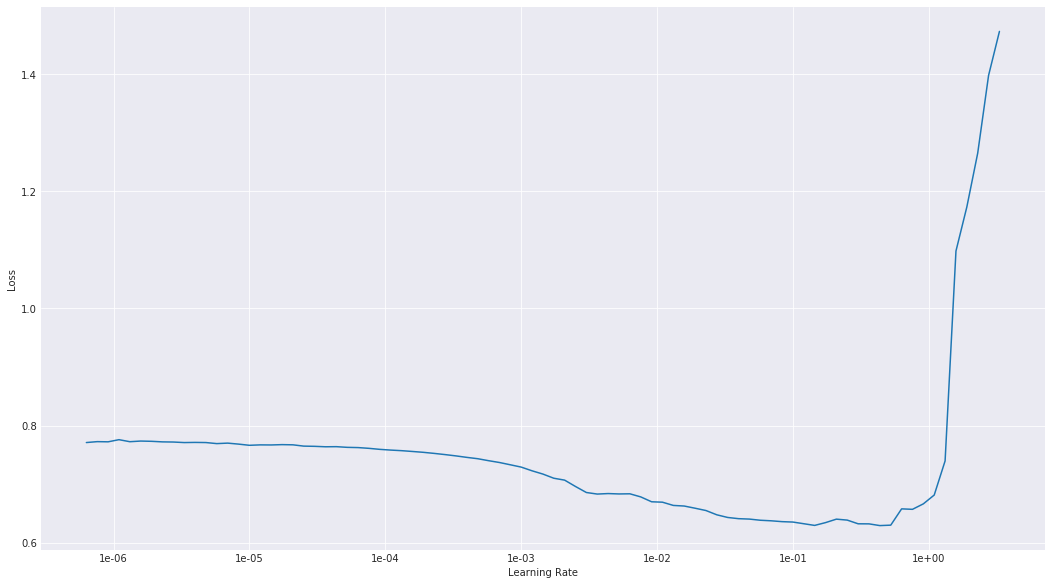

In [14]:
learner.recorder.plot()

In [15]:
learner.fit_one_cycle(3, 1e-1, callbacks=[save_model])

epoch,train_loss,valid_loss,fbeta
1,0.534754,0.523650,0.217396
2,0.506210,0.523641,0.217396
3,0.513994,0.523606,0.217396


In [14]:
learner = learner.load('wideresnet-01_3')

In [15]:
learner.unfreeze()

In [16]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


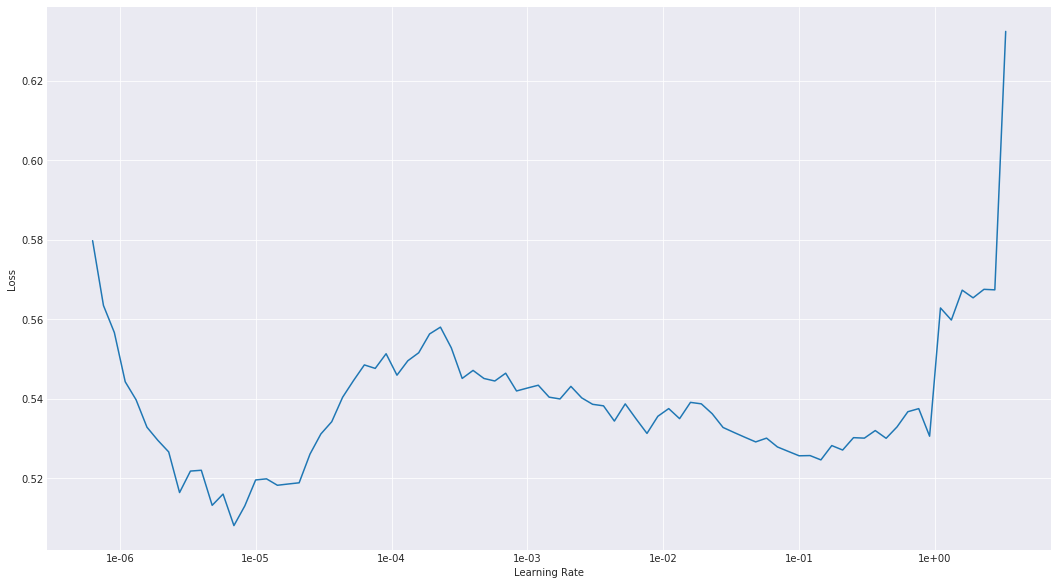

In [17]:
learner.recorder.plot()

## Parallel WideResnets 02

In [15]:
model_name = 'wideresnet_parallel-02'
learner = Learner(databunch, WideResNetParallel(vocab_size=VOCAB_SIZE, 
                                                 pretrained_wts_pth=PRETRAINED_PATH, 
                                                 emb_dim=EMB_SIZE,
                                                 n_grps=wrn_config.n_grps, 
                                                 N=wrn_config.n_blocks,
                                                 k=wrn_config.widening
                                       ), 
                  metrics=[fbeta])
learner.loss_func = nn.BCELoss()
save_model = SaveModelCallback(learner, every='epoch', name=model_name)

In [16]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


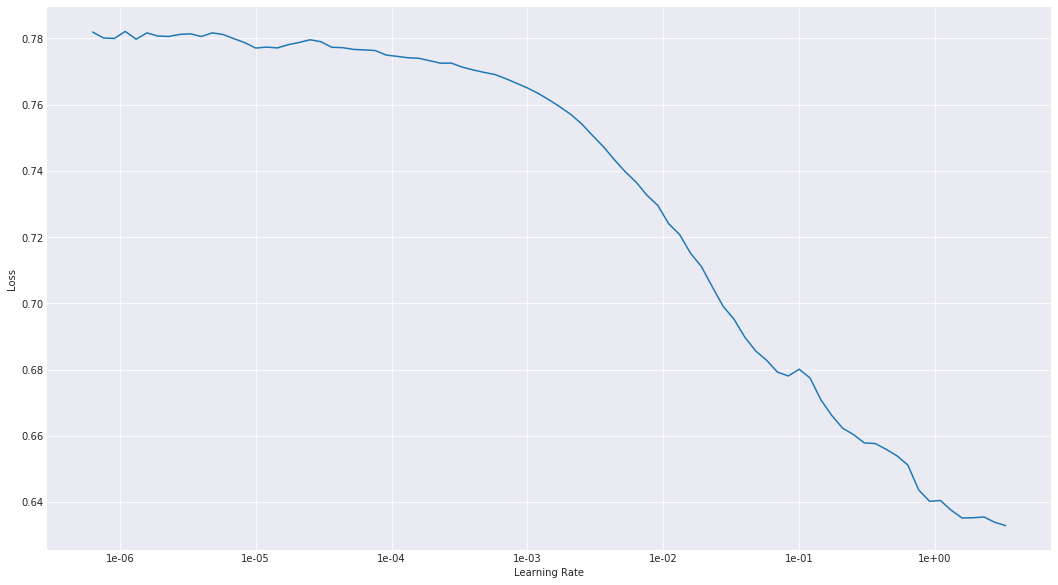

In [17]:
learner.recorder.plot()

In [20]:
learner.unfreeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


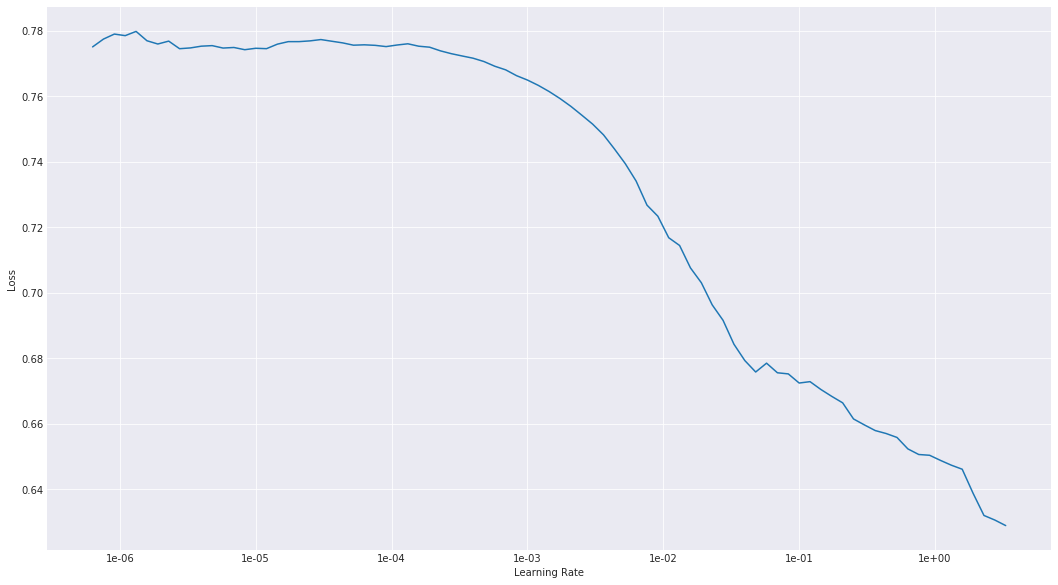

In [21]:
learner.recorder.plot()

In [22]:
learner.unfreeze()
learner.fit_one_cycle(4, 0.5, callbacks=[save_model])

epoch,train_loss,valid_loss,fbeta
1,0.536533,0.565868,0.217396


RuntimeError: CUDA error: unspecified launch failure